## 条件付き確率を用いたベイズ推定を活用

1. **事前確率の計算**:
   - 欠損している映画（例えば映画 $M$）の各評価値（0から5まで）の事前確率 $P(R_M = r)$ を計算します。これは、元データ全体での映画 \(M\) の評価値の分布から求めます。

2. **条件付き確率の取得**:
   - 欠損値以外の、ユーザーが評価した他の映画（例えば映画 $M_i$）について、その評価値 $r_i$ が与えられています。
   - クロス集計表から、各映画 \(M_i\) と欠損している映画 \(M\) の間の条件付き確率 $P(R_{M_i} = r_i | R_M = r))$ を取得します。

3. **尤度の計算**:
   - 各可能な評価値 \(r\)（0から5まで）について、以下のようにスコア（対数尤度）を計算します：
     $$
     \text{score}(r) = \log P(R_M = r) + \sum_{i} \log P(R_{M_i} = r_i | R_M = r)
     $$
   - これは、欠損している評価が \(r\) である場合の観測データの尤度を表します。

4. **最適な評価値の選択**:
   - 計算したスコアを比較し、最も高いスコアを持つ評価値 \(r\) を欠損値の推定値として選択します。

5. **例**:
   - 仮に欠損している映画が映画 260 で、ユーザーが評価した他の映画が映画 2174 で評価値が 3 であったとします。
   - 事前確率 \(P(R_{260} = r)\) は映画 260 の評価分布から得られます。
   - クロス集計表から \(P(R_{2174} = 3 | R_{260} = r)\) を取得します。
   - 各 \(r\) についてスコアを計算し、最も高いスコアの \(r\) を選択します。

6. **注意点**:
   - ユーザーが評価したすべての映画を使用すると計算量が増大するため、相関の高い映画や重要な映画に絞ることも検討できます。
   - データの独立性の仮定や、条件付き独立性の仮定に注意し、モデルの適用範囲を理解することが重要です。

この方法により、条件付き確率とベイズの定理を用いて、欠損値を合理的に推定することができます。

---

**まとめ**: クロス集計表から得られる条件付き確率と、各映画の評価分布から得られる事前確率を組み合わせて、欠損値の最も可能性の高い評価値を推定します。

In [106]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [107]:
ATTACK_TARGET = "20"
TARGET_TYPE = "MAIN" # MAIN: メインの攻撃, SUB: 予備選の攻撃, UTIL100: Utility100の攻撃
# MAIN = False # True: メインの攻撃, False: 予備選の攻撃

DIR = ""
if TARGET_TYPE == "MAIN":
    DIR = "../data"
elif TARGET_TYPE == "SUB":
    DIR = "../predata/anonymization_data"
elif TARGET_TYPE == "UTIL100":
    DIR = "../samples/util100"
    ATTACK_TARGET = "36"

"""
01	宮地研.exe
02	私達日本語本当下手
03	ポップコーン
04	Hots
05	SHA-NES
06	神ぼ大νττ
07	たけのこ映画守り隊
08	0xA
09	ステテコ泥棒
10	動的計画法
11	Gunmataro117
12	HAL
14	privocy
15	ES5 →多数決で陥落？
16	佐古研究室
17	こそっとアタック、しれっとブロック
18	匿名アノニマス
19	RITCHEY
20	KAT-TUNE
21	PR.AVATECT
22	春日部防衛隊（かすかべ防衛隊）
"""

'\n01\t宮地研.exe\n02\t私達日本語本当下手\n03\tポップコーン\n04\tHots\n05\tSHA-NES\n06\t神ぼ大νττ\n07\tたけのこ映画守り隊\n08\t0xA\n09\tステテコ泥棒\n10\t動的計画法\n11\tGunmataro117\n12\tHAL\n14\tprivocy\n15\tES5 →多数決で陥落？\n16\t佐古研究室\n17\tこそっとアタック、しれっとブロック\n18\t匿名アノニマス\n19\tRITCHEY\n20\tKAT-TUNE\n21\tPR.AVATECT\n22\t春日部防衛隊（かすかべ防衛隊）\n'

In [108]:
# fmt: off
ALL_HEADER = ['Name', 'Gender', 'Age', 'Occupation', 'ZIP-code', '2', '56', '247', '260', '653', '673', '810', '885',  # noqa: E501
                      '1009', '1073', '1097', '1126', '1525', '1654', '1702', '1750', '1881', '1920', '1967', '2017',  # noqa: E501
                      '2021', '2043', '2086', '2087', '2093', '2100', '2105', '2138', '2143', '2174', '2193', '2253',  # noqa: E501
                      '2399', '2628', '2797', '2872', '2968', '3393', '3438', '3439', '3440', '3466', '3479', '3489',  # noqa: E501
                      '3877', '3889'] # noqa

B_HEADERS_LIST = [
  ['Gender', 'Age', 'Occupation', 'ZIP-code', '260', '653', '1525', '2105', '2193', '2253', '2628', '2872', '3438', '3439', '3440', '3877', '3889'],  # noqa: E501
  ['Gender', 'Age', 'Occupation', 'ZIP-code', '2', '56', '260', '653', '673', '1009', '1073', '1525', '1750', '1881', '1967', '2043', '2093', '2105', '2143', '2193', '2399', '2628', '2968', '3479', '3489', '3877', '3889'],  # noqa: E501
  ['Gender', 'Age', 'Occupation', 'ZIP-code', '673', '1881', '1920', '2087', '2138'],  # noqa: E501
  ['Gender', 'Age', 'Occupation', 'ZIP-code', '2', '56', '673', '810', '885', '1009', '1073', '1097', '1525', '1654', '1702', '1750', '1881', '1920', '1967', '2017', '2043', '2087', '2093', '2138', '2399', '3438', '3439', '3440'],  # noqa: E501
  ['Gender', 'Age', 'Occupation', 'ZIP-code', '673', '810', '1073', '1126', '1702', '2100', '2174', '2253', '2797', '3393', '3466'],  # noqa: E501
  ['Gender', 'Age', 'Occupation', 'ZIP-code', '247', '885', '1097', '1654', '2086', '2138', '2872'],  # noqa: E501
  ['Gender', 'Age', 'Occupation', 'ZIP-code', '247', '2100', '2143', '2872', '3479'],  # noqa: E501
  ['Gender', 'Age', 'Occupation', 'ZIP-code', '260', '1097', '1750', '2021', '2093', '2105', '2628', '2968'],  # noqa: E501
  ['Gender', 'Age', 'Occupation', 'ZIP-code', '247', '1920', '2017', '2087'],  # noqa: E501
  ['Gender', 'Age', 'Occupation', 'ZIP-code', '260', '1097', '2628', '2174', '2797', '1073', '2100', '2968', '2105', '2193'],  # noqa: E501
]

B_USER_ATTRIBUTE_HEADERS = ['Gender', 'Age', 'Occupation', 'ZIP-code']

B_REVIEW_HEADERS_LIST = [
  ['260', '653', '1525', '2105', '2193', '2253', '2628', '2872', '3438', '3439', '3440', '3877', '3889'],  # noqa: E501
  ['2', '56', '260', '653', '673', '1009', '1073', '1525', '1750', '1881', '1967', '2043', '2093', '2105', '2143', '2193', '2399', '2628', '2968', '3479', '3489', '3877', '3889'],  # noqa: E501
  ['673', '1881', '1920', '2087', '2138'],  # noqa: E501
  ['2', '56', '673', '810', '885', '1009', '1073', '1097', '1525', '1654', '1702', '1750', '1881', '1920', '1967', '2017', '2043', '2087', '2093', '2138', '2399', '3438', '3439', '3440'],  # noqa: E501
  ['673', '810', '1073', '1126', '1702', '2100', '2174', '2253', '2797', '3393', '3466'],  # noqa: E501
  ['247', '885', '1097', '1654', '2086', '2138', '2872'],  # noqa: E501
  ['247', '2100', '2143', '2872', '3479'],  # noqa: E501
  ['260', '1097', '1750', '2021', '2093', '2105', '2628', '2968'],  # noqa: E501
  ['247', '1920', '2017', '2087'],  # noqa: E501
  ['260', '1097', '2628', '2174', '2797', '1073', '2100', '2968', '2105', '2193'],  # noqa: E501
]

MOVIE_IDS = ['2', '56', '247', '260', '653', '673', '810', '885', '1009', '1073', '1097', '1126', '1525', '1654', '1702', '1750', '1881', '1920', '1967', '2017', '2021', '2043', '2086', '2087', '2093', '2100', '2105', '2138', '2143', '2174', '2193', '2253', '2399', '2628', '2797', '2872', '2968', '3393', '3438', '3439', '3440', '3466', '3479', '3489', '3877', '3889']
# fmt: on

### CのデータとBa,Bbの読み取り

In [109]:
from os import listdir

#c0~c9に対するdfのリスト
c_data_list = []

files = listdir(DIR)

for i in range(10):
    file = None
    for f in files:
        if f.startswith(f"C{ATTACK_TARGET}_{i}"):
            file = f
            break
    if file is None:
        print(f)
        raise("File not found")
    c_data = pd.read_csv(f"{DIR}/C{ATTACK_TARGET}_{i}.csv")
    c_data_list.append(c_data)

c_data_list[0].head()

,Gender,Age,Occupation,ZIP-code,260,653,1525,2105,2193,2253,2628,2872,3438,3439,3440,3877,3889
0,M,35,15,6,4,5,4,2,2,3,1,0,0,2,3,0,0
1,F,18,9,6,0,0,1,4,5,3,4,0,0,1,0,0,4
2,M,18,10,6,0,0,0,5,4,5,3,0,1,0,2,0,5
3,F,45,7,6,1,3,1,2,0,0,1,1,0,0,2,0,4
4,M,25,2,6,1,0,2,5,5,5,3,0,5,3,0,2,0


In [110]:
Ba = pd.read_csv(f"{DIR}/B{ATTACK_TARGET}a.csv")
Ba.head()

,Name,Gender,Age,Occupation,ZIP-code
0,Ilaire Garett,M,50,17,109
1,Timofei Chastenet,M,25,16,945
2,Jule Sahnow,M,45,1,282
3,Eldon Janusik,M,35,4,735
4,Chuck Caren,M,45,17,927


In [111]:
Bb = pd.read_csv(f"{DIR}/B{ATTACK_TARGET}b.csv")
Bb.head()

,2,56,247,260,653,673,810,885,1009,1073,...,2968,3393,3438,3439,3440,3466,3479,3489,3877,3889
0,0,4,0,4,0,3,0,0,2,*,...,0,4,5,1,0,0,2,5,2,4
1,1,0,1,5,2,2,2,2,0,5,...,0,1,0,0,0,1,0,0,0,5
2,1,0,0,4,3,4,3,2,0,0,...,2,3,0,1,0,5,0,1,3,3
3,2,4,2,5,5,5,0,0,*,0,...,5,2,5,2,3,1,3,3,2,0
4,0,0,1,5,1,1,0,1,5,5,...,0,4,0,1,2,0,0,1,0,0


### クロス集計の存在する映画のIDの全ペア

In [112]:
import itertools

cross_tab_pairs = []

pairs_set = set()
for b_review_headers in B_REVIEW_HEADERS_LIST:
    for pair in itertools.combinations(b_review_headers, 2):
        pairs_set.add(pair)

for pair in itertools.combinations(MOVIE_IDS, 2):
    if pair in pairs_set:
        cross_tab_pairs.append(pair)

print(f"ペアの数: {len(cross_tab_pairs)}")
cross_tab_pairs[:5]

ペアの数: 607


[('2', '56'), ('2', '260'), ('2', '653'), ('2', '673'), ('2', '810')]

### C0~C9の各cross集計の平均をとる

In [113]:
# 1. c0からc9までのデータを結合
combined_data = pd.concat(c_data_list, ignore_index=True)
combined_data.astype("category")
for col in MOVIE_IDS:
    combined_data[col] = pd.Categorical(combined_data[col], categories=[0, 1, 2, 3, 4, 5], ordered=True)


# 2. cross_tab_pairsごとにクロス集計を行う
cross_tabs = {}
for movie_id_i, movie_id_j in cross_tab_pairs:
    cross_tab = pd.crosstab(combined_data[movie_id_i], combined_data[movie_id_j], normalize='all')
    cross_tabs[(movie_id_i, movie_id_j)] = cross_tab

cross_tabs[("260", "2174")]

2174,0,1,2,3,4,5
260,,,,,,
0,0.0293,0.0137,0.0201,0.0230,0.0168,0.0217
1,0.0302,0.0164,0.0205,0.0222,0.0157,0.0203
2,0.0272,0.0123,0.0192,0.0179,0.0154,0.0186
3,0.0169,0.0086,0.0119,0.0118,0.0091,0.0132
4,0.0649,0.0313,0.0469,0.0454,0.0338,0.0421
5,0.0767,0.0336,0.0499,0.0527,0.0434,0.0473


In [114]:
combined_data.head()

,Gender,Age,Occupation,ZIP-code,260,653,1525,2105,2193,2253,...,2017,1126,2100,2174,2797,3393,3466,247,2086,2021
0,M,35,15,6,4,5,4,2,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F,18,9,6,0,0,1,4,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M,18,10,6,0,0,0,5,4,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,F,45,7,6,1,3,1,2,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M,25,2,6,1,0,2,5,5,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## データの可視化

### 元データの分布の確認

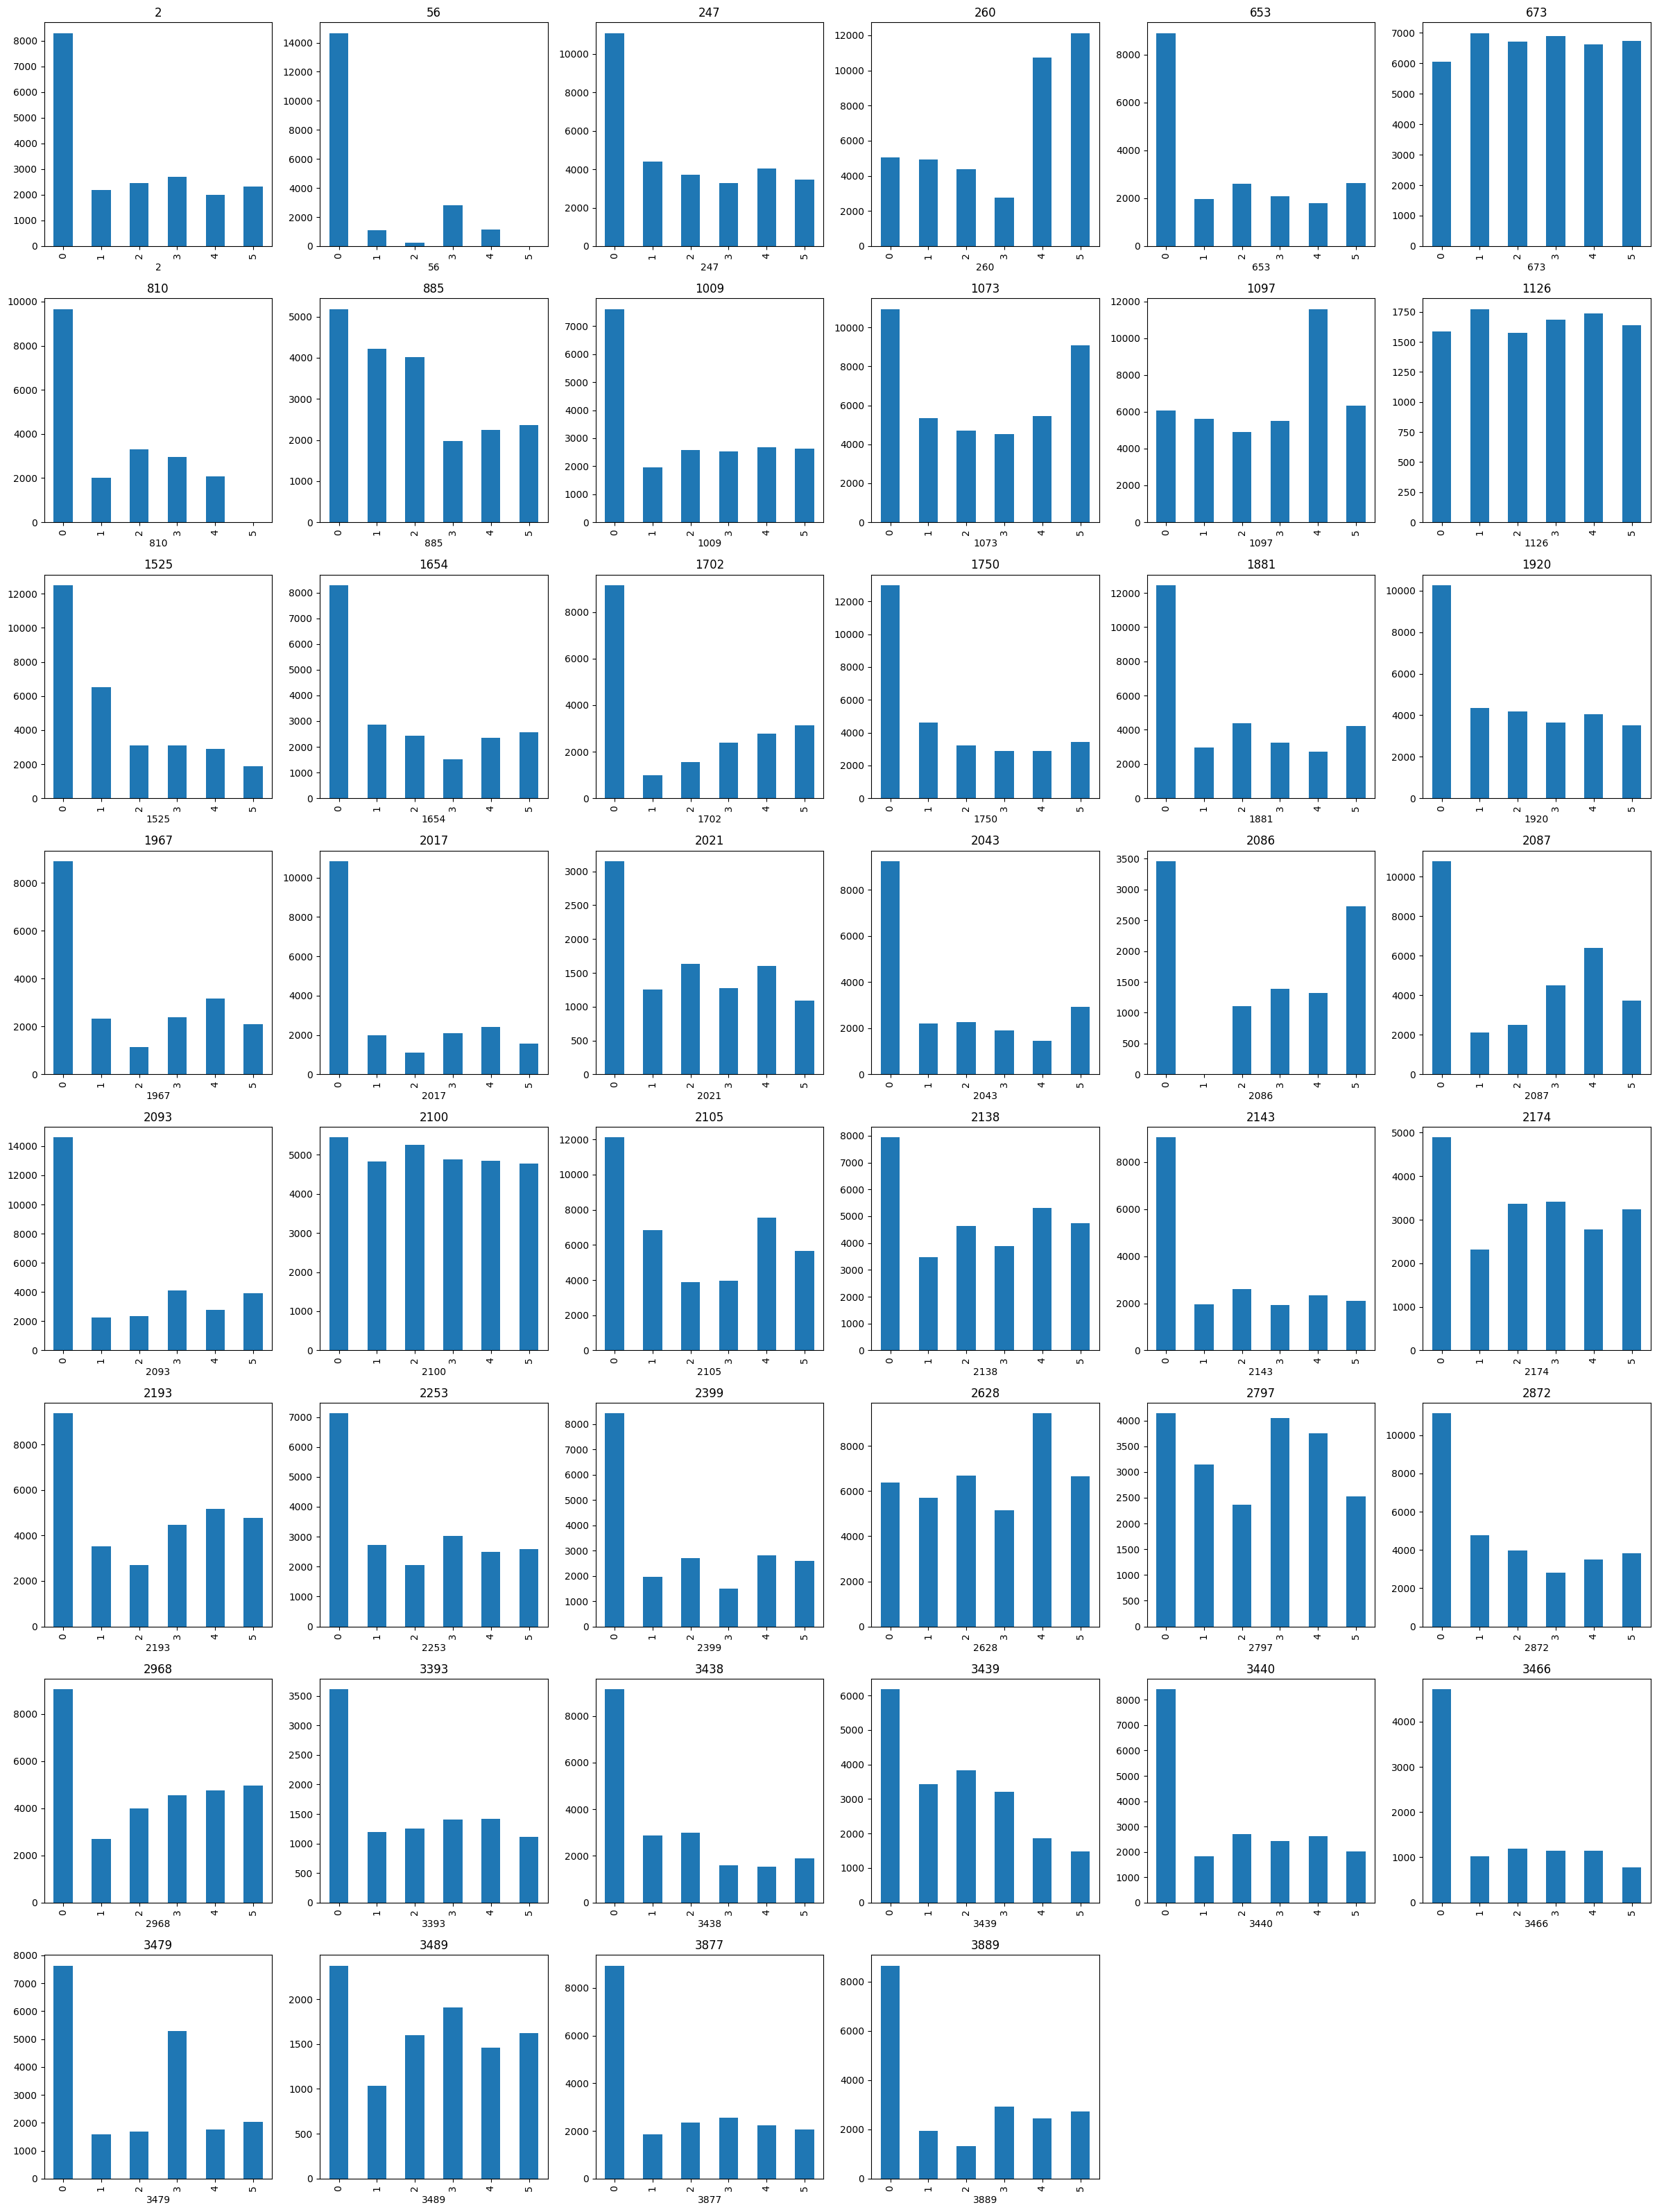

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# combined_dataが既に定義されていると仮定します

# カラムの総数を取得
num_cols = len(MOVIE_IDS)
# 列数を6に設定
num_per_row = 6
# 必要な行数を計算
num_rows = int(np.ceil(num_cols / num_per_row))

# サブプロットを作成
fig, axes = plt.subplots(nrows=num_rows, ncols=num_per_row, figsize=(24, num_rows * 4))
axes = axes.flatten()

# # 各カラムに対して棒グラフを描画
for i, col in enumerate(MOVIE_IDS):
    value_counts = combined_data[col].value_counts().sort_index()
    value_counts.plot(kind='bar', ax=axes[i])
    axes[i].set_title(col)

# 余ったサブプロットを削除
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Bbの特定の行を選択し、穴となる映画のIDを取得

In [116]:
# Bbの指定した行を取得
target_Bb_row_index = 45
target_Bb_row = Bb.iloc[target_Bb_row_index]
target_Bb_row[:8]

2      4
56     0
247    3
260    3
653    0
673    3
810    4
885    0
Name: 45, dtype: object

In [117]:
hidden_movie_id = None
for movie_id in MOVIE_IDS:
    if target_Bb_row[movie_id] == "*":
        hidden_movie_id = movie_id
        break
hidden_movie_id

'2086'

In [118]:
prior_probabilities_for_target_movie_id = combined_data[hidden_movie_id].value_counts(normalize=True)
prior_probabilities_for_target_movie_id

2086
0    0.3458
5    0.2731
3    0.1393
4    0.1316
2    0.1102
1    0.0000
Name: proportion, dtype: float64

In [119]:
cross_tabs_with_hidden_movie = []

for movie_id_i, movie_id_j in cross_tab_pairs:
    if hidden_movie_id not in (movie_id_i, movie_id_j):
        continue
    cross_tab = cross_tabs[(movie_id_i, movie_id_j)]
    paired_movie_id = None
    if hidden_movie_id == movie_id_i:
        paired_movie_id = movie_id_j
        # hidden_movie_idを縦の配置に揃えたいので、転置する
        cross_tab = cross_tab.T
    else:
        paired_movie_id = movie_id_i

    review_value = target_Bb_row[paired_movie_id]
    target_cross_tab = cross_tab.loc[int(review_value)]
    cross_tabs_with_hidden_movie.append(target_cross_tab)

cross_tabs_with_hidden_movie = pd.concat(cross_tabs_with_hidden_movie, axis=1)
cross_tabs_with_hidden_movie

,3,0,5,4,0,2
2086,,,,,,
0,0.0393,0.0893,0.0546,0.0399,0.0926,0.0430
2,0.0103,0.0289,0.0182,0.0144,0.0299,0.0137
3,0.0124,0.0328,0.0239,0.0179,0.0383,0.0216
4,0.0150,0.0339,0.0201,0.0148,0.0375,0.0188
5,0.0289,0.0702,0.0430,0.0316,0.0719,0.0345


In [120]:
column_sums = cross_tabs_with_hidden_movie.sum()

# 各値を対応するカラムの合計で割って正規化
normalized_cross_tabs_with_hidden_movie = cross_tabs_with_hidden_movie.div(column_sums, axis=1)
normalized_cross_tabs_with_hidden_movie

,3,0,5,4,0,2
2086,,,,,,
0,0.371105,0.350059,0.341677,0.336425,0.342709,0.326748
2,0.097262,0.113289,0.113892,0.121417,0.110659,0.104103
3,0.117092,0.128577,0.149562,0.150927,0.141747,0.164134
4,0.141643,0.132889,0.125782,0.124789,0.138786,0.142857
5,0.272899,0.275186,0.269086,0.266442,0.266099,0.262158


In [121]:
def score(r, prior_probabilities, normalized_cross_tabs_with_hidden_movie):
    score = 0
    score += np.log(prior_probabilities[r])
    for i in range(len(normalized_cross_tabs_with_hidden_movie.columns)):
        score += np.log(normalized_cross_tabs_with_hidden_movie.iloc[r, i])
    return score

scores = []
for r in range(6):
    scores.append(score(r, prior_probabilities_for_target_movie_id, normalized_cross_tabs_with_hidden_movie))

scores

/var/folders/22/sn7bjw057h54_810zqj94q680000gn/T/ipykernel_84694/644273099.py:3: RuntimeWarning: divide by zero encountered in log
  score += np.log(prior_probabilities[r])


IndexError: index 5 is out of bounds for axis 0 with size 5

### 対数なので最も小さい値が採用

In [94]:
np.argmax(scores)

0

In [122]:
def ensure_complete_crosstab(cross_tab):
    # return cross_tab
    all_ratings = range(6)  # 0から5までの評価
    for rating in all_ratings:
        if rating not in cross_tab.index:
            cross_tab.loc[rating] = 0
        if rating not in cross_tab.columns:
            cross_tab[rating] = 0
    return cross_tab.sort_index(axis=0).sort_index(axis=1)

cross_tabs_with_hidden_movie = []

for movie_id_i, movie_id_j in cross_tab_pairs:
    if hidden_movie_id not in (movie_id_i, movie_id_j):
        continue

    # 欠損映画が行、観測映画が列になるようにクロス集計表を構築
    if hidden_movie_id == movie_id_i:
        cross_tab = pd.crosstab(combined_data[hidden_movie_id], combined_data[movie_id_j])
    else:
        cross_tab = pd.crosstab(combined_data[hidden_movie_id], combined_data[movie_id_i])
    cross_tab = ensure_complete_crosstab(cross_tab)

    # 条件付き確率を計算
    conditional_prob = cross_tab.div(cross_tab.sum(axis=1), axis=0)

    # 観測された評価値
    observed_value = int(target_Bb_row[paired_movie_id])

    # 欠損映画の各評価値に対する条件付き確率を取得
    target_probs = conditional_prob[observed_value]

    cross_tabs_with_hidden_movie.append(target_probs)

# データフレームに結合
conditional_probs_df = pd.concat(cross_tabs_with_hidden_movie, axis=1)

# スコアの計算
epsilon = 1e-10  # ゼロ割りを防ぐための小さな値
scores = []
for r in range(6):
    log_prior = np.log(prior_probabilities_for_target_movie_id.get(r, epsilon))
    log_likelihood = np.sum(np.log(conditional_probs_df.loc[r] + epsilon))
    scores.append(log_prior + log_likelihood)

print(scores)

# 最も高いスコアの評価値を選択
predicted_rating = np.argmax(scores)
predicted_rating

[-12.775357256775445, -inf, -14.362898111660755, -13.63669249842432, -13.71545615076338, -13.135667309555489]


/var/folders/22/sn7bjw057h54_810zqj94q680000gn/T/ipykernel_84694/2225516019.py:42: RuntimeWarning: divide by zero encountered in log
  log_prior = np.log(prior_probabilities_for_target_movie_id.get(r, epsilon))


0

In [123]:
# results_df["Predicted_Rating"]

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

# my_answer = list(result_list)

if TARGET_TYPE == "SUB":
    Bx = pd.read_csv(f"{DIR}/B{ATTACK_TARGET}x.csv", header=None)
    X_ANSWER = Bx[1].values

    print(X_ANSWER)
    # print(my_answer)

    # matched_count = sum([1 for i in range(50) if my_answer[i] == X_ANSWER[i]])
    # printmd(f"マッチングの成功率: <span style='color:yellow'>{matched_count}</span> / 50")

if TARGET_TYPE == "UTIL100":
    Bx = pd.read_csv(f"{DIR}/B{ATTACK_TARGET}x.csv", header=None)
    X_ANSWER = Bx[1].values

    print(X_ANSWER)
    # print(my_answer)

    # matched_count = sum([1 for i in range(50) if my_answer[i] == X_ANSWER[i]])
    # printmd(f"マッチングの成功率: <span style='color:yellow'>{matched_count}</span> / 50")

In [124]:
# Bbの全ての行に対して予測を行う
predicted_ratings = []

for target_Bb_row_index in range(50):
    # Bbの指定した行を取得
    target_Bb_row = Bb.iloc[target_Bb_row_index]

    # 欠損している映画のIDを特定
    hidden_movie_id = None
    for movie_id in MOVIE_IDS:
        if target_Bb_row[movie_id] == "*":
            hidden_movie_id = movie_id
            break
    if hidden_movie_id is None:
        # 欠損値がない場合はスキップ
        predicted_ratings.append(None)
        continue

    # 欠損映画の事前確率を計算
    prior_probabilities_for_target_movie_id = combined_data[hidden_movie_id].value_counts(normalize=True)
    prior_probabilities_for_target_movie_id = prior_probabilities_for_target_movie_id.sort_index()
    # 欠損映画の評価値（0から5まで）をリスト化
    possible_ratings = [0, 1, 2, 3, 4, 5]

    # スコアを初期化
    scores = []

    # 観測された映画のIDと評価値のペアを取得
    observed_movies = {}
    for movie_id in MOVIE_IDS:
        if movie_id != hidden_movie_id:
            observed_value = target_Bb_row[movie_id]
            if observed_value != '*':
                observed_movies[movie_id] = int(observed_value)

    # 各評価値に対してスコアを計算
    for r in possible_ratings:
        # 対数事前確率を計算
        epsilon = 1e-20  # ゼロ割り防止のための小さい値
        prior_prob = prior_probabilities_for_target_movie_id.get(r, epsilon)
        log_prior = np.log(prior_prob + epsilon)

        log_likelihood = 0
        # 観測された映画ごとに条件付き確率を計算
        for observed_movie_id, observed_value in observed_movies.items():
            # 映画IDの順序を決定
            movie_id_i, movie_id_j = sorted([hidden_movie_id, observed_movie_id])

            # クロス集計表を取得
            cross_tab = cross_tabs.get((movie_id_i, movie_id_j), None)
            if cross_tab is None:
                continue  # クロス集計表がない場合はスキップ

            # 欠損映画が行、観測映画が列になるように調整
            if hidden_movie_id == movie_id_i:
                # そのままでOK
                pass
            else:
                # 転置する
                cross_tab = cross_tab.T

            # 条件付き確率を計算
            conditional_prob = cross_tab.div(cross_tab.sum(axis=1), axis=0)

            # 条件付き確率が存在するか確認
            if r in conditional_prob.index and observed_value in conditional_prob.columns:
                prob = conditional_prob.at[r, observed_value]
                log_likelihood += np.log(prob + epsilon)
            else:
                # データがない場合は極小値を使用
                log_likelihood += np.log(epsilon)

        # 総スコアを計算
        total_score = log_prior + log_likelihood
        scores.append(total_score)

    # 最も高いスコアの評価値を選択
    predicted_rating = np.argmax(scores)
    predicted_ratings.append(predicted_rating)

# 結果をデータフレームにまとめる
results_df = pd.DataFrame({
    'Index': range(50),
    'Predicted_Rating': predicted_ratings
})
results_df

,Index,Predicted_Rating
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,1
6,6,3
7,7,0
8,8,5
9,9,0


In [125]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

# 実際の値と比較（Bxが存在する場合）
if TARGET_TYPE == "SUB" or TARGET_TYPE == "UTIL100":
    Bx = pd.read_csv(f"{DIR}/B{ATTACK_TARGET}x.csv", header=None)
    true_ratings = Bx[1].astype(int).values

    print(true_ratings)
    print(np.array(predicted_ratings))

    # 正解率を計算
    matched_count = sum([1 for pred, true in zip(predicted_ratings, true_ratings) if pred == true])
    accuracy = matched_count / 50 * 100
    printmd(f"マッチングの成功率: <span style='color:yellow'>{matched_count}</span> / 50 ({accuracy}%)")

In [126]:
count_0 = predicted_ratings.count(0)

printmd(f"0の数: <span style='color:green'>{count_0}</span>")
if count_0 >= 30:
    printmd("🚨 <span style='color:yellow'>0が30以上です</span>")

0の数: <span style='color:green'>37</span>

🚨 <span style='color:yellow'>0が30以上です</span>

In [127]:
# Bbの全ての行に対して予測を行う
predicted_ratings = []

for target_Bb_row_index in range(50):
    # Bbの指定した行を取得
    target_Bb_row = Bb.iloc[target_Bb_row_index]

    # 欠損している映画のIDを特定
    hidden_movie_id = None
    for movie_id in MOVIE_IDS:
        if target_Bb_row[movie_id] == "*":
            hidden_movie_id = movie_id
            break
    if hidden_movie_id is None:
        # 欠損値がない場合はスキップ
        predicted_ratings.append(None)
        continue

    # 欠損映画の事前確率を計算
    prior_probabilities_for_target_movie_id = combined_data[hidden_movie_id].value_counts(normalize=True)
    prior_probabilities_for_target_movie_id = prior_probabilities_for_target_movie_id.sort_index()
    # 欠損映画の評価値（0から5まで）をリスト化
    possible_ratings = [0, 1, 2, 3, 4, 5]

    # スコアを初期化
    scores = []

    # 観測された映画のIDと評価値のペアを取得
    observed_movies = {}
    for movie_id in MOVIE_IDS:
        if movie_id != hidden_movie_id:
            observed_value = target_Bb_row[movie_id]
            if observed_value != '*':
                observed_movies[movie_id] = int(observed_value)

    # 各評価値に対してスコアを計算
    for r in possible_ratings:
        # 対数事前確率を計算
        epsilon = 1e-10  # ゼロ割り防止のための小さい値
        prior_prob = prior_probabilities_for_target_movie_id.get(r, epsilon)
        log_prior = np.log(prior_prob + epsilon)

        log_likelihood = 0
        # 観測された映画ごとに条件付き確率を計算
        for observed_movie_id, observed_value in observed_movies.items():
            # 映画IDの順序を決定
            movie_id_i, movie_id_j = sorted([hidden_movie_id, observed_movie_id])

            # クロス集計表を取得
            cross_tab = cross_tabs.get((movie_id_i, movie_id_j), None)
            if cross_tab is None:
                continue  # クロス集計表がない場合はスキップ

            # 欠損映画が行、観測映画が列になるように調整
            if hidden_movie_id == movie_id_i:
                # そのままでOK
                pass
            else:
                # 転置する
                cross_tab = cross_tab.T

            # 条件付き確率を計算
            conditional_prob = cross_tab.div(cross_tab.sum(axis=1), axis=0)

            # 条件付き確率が存在するか確認
            if r in conditional_prob.index and observed_value in conditional_prob.columns:
                prob = conditional_prob.at[r, observed_value]
                log_likelihood += np.log(prob + epsilon)
            else:
                # データがない場合は極小値を使用
                log_likelihood += np.log(epsilon)

        # 総スコアを計算
        total_score = log_prior + log_likelihood
        scores.append(total_score)

    # 最も高いスコアの評価値を選択
    predicted_rating = np.argmax(scores)
    predicted_ratings.append(predicted_rating)

# 結果をデータフレームにまとめる
results_df = pd.DataFrame({
    'Index': range(50),
    'Predicted_Rating': predicted_ratings
})

results_df

,Index,Predicted_Rating
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,1
6,6,3
7,7,0
8,8,5
9,9,0


In [128]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

# 実際の値と比較（Bxが存在する場合）
if TARGET_TYPE == "SUB" or TARGET_TYPE == "UTIL100":
    Bx = pd.read_csv(f"{DIR}/B{ATTACK_TARGET}x.csv", header=None)
    true_ratings = Bx[1].astype(int).values

    print(true_ratings)
    print(np.array(predicted_ratings))

    # 正解率を計算
    matched_count = sum([1 for pred, true in zip(predicted_ratings, true_ratings) if pred == true])
    accuracy = matched_count / 50 * 100
    printmd(f"マッチングの成功率: <span style='color:yellow'>{matched_count}</span> / 50 ({accuracy}%)")

In [129]:
count_0 = predicted_ratings.count(0)

printmd(f"0の数: <span style='color:green'>{count_0}</span>")
if count_0 >= 30:
    printmd("🚨 <span style='color:yellow'>0が30以上です</span>")

0の数: <span style='color:green'>37</span>

🚨 <span style='color:yellow'>0が30以上です</span>

In [130]:
def compute_movie_correlations(combined_data, target_movie_id):
    correlations = {}
    target_movie_ratings = combined_data[target_movie_id]
    for movie_id in MOVIE_IDS:
        if movie_id != target_movie_id:
            movie_ratings = combined_data[movie_id]
            # 両方の映画を評価しているユーザーのみを抽出
            common_indices = target_movie_ratings[(target_movie_ratings != '*') & (movie_ratings != '*')].index
            if len(common_indices) > 0:
                ratings1 = target_movie_ratings.loc[common_indices].astype(float)
                ratings2 = movie_ratings.loc[common_indices].astype(float)
                # ピアソン相関係数を計算
                correlation = ratings1.corr(ratings2)
                if not np.isnan(correlation):
                    correlations[movie_id] = correlation
    return correlations


# Bbの全ての行に対して予測を行う
predicted_ratings = []

for target_Bb_row_index in range(50):
    # Bbの指定した行を取得
    target_Bb_row = Bb.iloc[target_Bb_row_index]

    # 欠損している映画のIDを特定
    hidden_movie_id = None
    for movie_id in MOVIE_IDS:
        if target_Bb_row[movie_id] == "*":
            hidden_movie_id = movie_id
            break
    if hidden_movie_id is None:
        # 欠損値がない場合はスキップ
        predicted_ratings.append(None)
        continue

    # 欠損映画の事前確率を計算
    prior_probabilities_for_target_movie_id = combined_data[hidden_movie_id].value_counts(normalize=True)
    prior_probabilities_for_target_movie_id = prior_probabilities_for_target_movie_id.sort_index()
    # 欠損映画の評価値（0から5まで）をリスト化
    possible_ratings = [0, 1, 2, 3, 4, 5]

    # スコアを初期化
    scores = []

    # 観測された映画のIDと評価値のペアを取得
    observed_movies = {}
    for movie_id in MOVIE_IDS:
        if movie_id != hidden_movie_id:
            observed_value = target_Bb_row[movie_id]
            if observed_value != '*':
                observed_movies[movie_id] = int(observed_value)

    movie_correlations = compute_movie_correlations(combined_data, hidden_movie_id)

    K = 5  # これは調整可能なハイパーパラメータ
    top_k_movies = sorted(movie_correlations, key=movie_correlations.get, reverse=True)[:K]
    observed_movies = {movie_id: observed_movies[movie_id] for movie_id in top_k_movies if movie_id in observed_movies}

    # 各評価値に対してスコアを計算
    for r in possible_ratings:
        
        weight = movie_correlations.get(observed_movie_id, 0)
        # 対数事前確率を計算
        epsilon = 1e-10  # ゼロ割り防止のための小さい値
        prior_prob = prior_probabilities_for_target_movie_id.get(r, epsilon)
        log_prior = np.log(prior_prob + epsilon)

        log_likelihood = 0
        # 観測された映画ごとに条件付き確率を計算
        for observed_movie_id, observed_value in observed_movies.items():
            # 映画IDの順序を決定
            movie_id_i, movie_id_j = sorted([hidden_movie_id, observed_movie_id])

            # クロス集計表を取得
            cross_tab = cross_tabs.get((movie_id_i, movie_id_j), None)
            if cross_tab is None:
                continue  # クロス集計表がない場合はスキップ

            # 欠損映画が行、観測映画が列になるように調整
            if hidden_movie_id == movie_id_i:
                # そのままでOK
                pass
            else:
                # 転置する
                cross_tab = cross_tab.T

            # 条件付き確率を計算
            conditional_prob = cross_tab.div(cross_tab.sum(axis=1), axis=0)

            # 条件付き確率が存在するか確認
            if r in conditional_prob.index and observed_value in conditional_prob.columns:
                # prob = conditional_prob.at[r, observed_value]
                prob = conditional_prob.at[r, observed_value] if (r in conditional_prob.index and observed_value in conditional_prob.columns) else epsilon
                log_likelihood += np.log(prob + epsilon)
            else:
                # データがない場合は極小値を使用
                log_likelihood += np.log(epsilon)

        # 総スコアを計算
        total_score = log_prior + log_likelihood
        scores.append(total_score)

    # 最も高いスコアの評価値を選択
    predicted_rating = np.argmax(scores)
    predicted_ratings.append(predicted_rating)

# 結果をデータフレームにまとめる
results_df = pd.DataFrame({
    'Index': range(50),
    'Predicted_Rating': predicted_ratings
})

results_df

,Index,Predicted_Rating
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,1
6,6,1
7,7,0
8,8,4
9,9,0


In [131]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

# 実際の値と比較（Bxが存在する場合）
if TARGET_TYPE == "SUB" or TARGET_TYPE == "UTIL100":
    Bx = pd.read_csv(f"{DIR}/B{ATTACK_TARGET}x.csv", header=None)
    true_ratings = Bx[1].astype(int).values

    print(true_ratings)
    print(np.array(predicted_ratings))

    # 正解率を計算
    matched_count = sum([1 for pred, true in zip(predicted_ratings, true_ratings) if pred == true])
    accuracy = matched_count / 50 * 100
    printmd(f"マッチングの成功率: <span style='color:yellow'>{matched_count}</span> / 50 ({accuracy}%)")

In [132]:
count_0 = list(predicted_ratings).count(0)

printmd(f"0の数: <span style='color:green'>{count_0}</span>")
if count_0 >= 30:
    printmd(f"🚨 <span style='color:yellow'>0が30以上です</span>")

0の数: <span style='color:green'>38</span>

🚨 <span style='color:yellow'>0が30以上です</span>